In [1]:
# Importing all the necessary packages
from __future__ import absolute_import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import json
import pickle
import random
import logging
import warnings
from io import open
from itertools import cycle
from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, SequentialSampler, RandomSampler, TensorDataset
from torch.utils.data.distributed import DistributedSampler
from transformers import WEIGHTS_NAME, AdamW, get_linear_schedule_with_warmup
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer

from model import Seq2Seq
import bleu

warnings.filterwarnings('ignore')
sns.set()
%matplotlib inline

In [2]:
# Use multiple GPU cores
os.environ["CUDA_VISIBLE_DEVICES"] = "1, 2, 3"

In [3]:
# Set configurations
MODEL_CLASSES = {'roberta': (RobertaConfig, RobertaModel, RobertaTokenizer)}

logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s', datefmt='%m/%d/%Y %H:%M:%S', level=logging.INFO)
logger = logging.getLogger(__name__)

In [4]:
# Parameters
lang                 = 'ruby'
data_dir             = 'dataset'
load_model_path      = None
output_dir           = os.path.join('outputs_codebert', lang)
load_model_path_test = os.path.join(output_dir, 'checkpoint-best-ppl', 'checkpoint-best-bleu', 'pytorch_model.bin') #checkpoint for test
train_filename       = os.path.join(data_dir, lang, 'train_sample.jsonl') # 'train.jsonl'
dev_filename         = os.path.join(data_dir, lang, 'valid_sample.jsonl') # 'valid.jsonl'
test_filename        = os.path.join(data_dir, lang, 'test_sample.jsonl') # 'test.jsonl'
do_train             = True
do_eval              = True
do_test              = False

In [5]:
# Hyper-parameters
model_type           = 'roberta'
model_name_or_path   = 'microsoft/codebert-base'

config_name       = ""
tokenizer_name    = ""
max_source_length = 256
max_target_length = 128

do_lower_case = False
no_cuda       = False

num_train_epochs            = 3
train_batch_size            = 32
eval_batch_size             = 32
test_batch_size             = 64
learning_rate               = 5e-5
seed                        = 10

beam_size                   = 10
gradient_accumulation_steps = 1
weight_decay                = 0.0
adam_epsilon                = 1e-8
max_grad_norm               = 1.0
max_steps                   = -1
train_steps                 = -1
eval_steps                  = -1
warmup_steps                = 0
local_rank                  = -1

## Utility Functions

In [6]:
def set_seed(seed=10):
    random.seed(seed)
    os.environ['PYHTONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [7]:
class Example(object):
    """A single training/test example."""
    def __init__(self, idx, source, target):
        self.idx    = idx
        self.source = source
        self.target = target

def read_examples(filename):
    """Read examples from filename."""
    examples = []
    with open(filename, encoding="utf-8") as f:
        for idx, line in enumerate(f):
            line = line.strip()
            js   = json.loads(line)
            if 'idx' not in js:
                js['idx'] = idx
            code = ' '.join(js['code_tokens']).replace('\n', ' ')
            code = ' '.join(code.strip().split())
            nl   = ' '.join(js['docstring_tokens']).replace('\n', '')
            nl   = ' '.join(nl.strip().split())
            examples.append(Example(idx=idx, source=code, target=nl))

    return examples

In [8]:
class InputFeatures(object):
    """A single training/test features for a example."""
    def __init__(self, example_id, source_ids, target_ids, source_mask, target_mask):
        self.example_id  = example_id
        self.source_ids  = source_ids
        self.target_ids  = target_ids
        self.source_mask = source_mask
        self.target_mask = target_mask

def convert_examples_to_features(examples, tokenizer, stage=None, 
                                max_source_length=256, max_target_length=128):
    features = []
    for example_index, example in enumerate(examples):
        # source
        source_tokens   = tokenizer.tokenize(example.source)[:max_source_length-2]
        source_tokens   = [tokenizer.cls_token] + source_tokens + [tokenizer.sep_token]
        source_ids      = tokenizer.convert_tokens_to_ids(source_tokens)
        source_mask     = [1] * (len(source_tokens))
        padding_length  = max_source_length - len(source_ids)
        source_ids     += [tokenizer.pad_token_id] * padding_length
        source_mask    += [0] * padding_length

        # target
        if stage == "test":
            target_tokens = tokenizer.tokenize("None")
        else:
            target_tokens = tokenizer.tokenize(example.target)[:max_target_length-2]

        target_tokens  = [tokenizer.cls_token] + target_tokens + [tokenizer.sep_token]
        target_ids     = tokenizer.convert_tokens_to_ids(target_tokens)
        target_mask    = [1] * len(target_ids)
        padding_length = max_target_length - len(target_ids)
        target_ids    += [tokenizer.pad_token_id] * padding_length
        target_mask   += [0] * padding_length

        features.append(InputFeatures(example_index, source_ids, target_ids, source_mask, target_mask))

    return features

## Environment Setup

In [9]:
# Setup CUDA, GPU & distributed training
if local_rank == -1 or no_cuda:
    device = torch.device("cuda" if torch.cuda.is_available() and not no_cuda else "cpu")
    n_gpu  = torch.cuda.device_count()
else:  # Initializes the distributed backend which will take care of sychronizing nodes/GPUs
    torch.cuda.set_device(local_rank)
    device = torch.device("cuda", local_rank)
    torch.distributed.init_process_group(backend='nccl')
    n_gpu  = 1
# logger.warning("Process rank: %s, device: %s, n_gpu: %s, distributed training: %s", local_rank, device, n_gpu, bool(local_rank != -1))

# Set seed
set_seed(seed)

# make dir if output_dir not exist
if os.path.exists(output_dir) is False:
    os.makedirs(output_dir)

config_class, model_class, tokenizer_class = MODEL_CLASSES[model_type]
config    = config_class.from_pretrained(config_name if config_name else model_name_or_path)
tokenizer = tokenizer_class.from_pretrained(tokenizer_name if tokenizer_name else model_name_or_path, do_lower_case=do_lower_case)

# build model
encoder       = model_class.from_pretrained(model_name_or_path, config=config)
decoder_layer = nn.TransformerDecoderLayer(d_model=config.hidden_size, nhead=config.num_attention_heads)
decoder       = nn.TransformerDecoder(decoder_layer, num_layers=6)
model         = Seq2Seq(encoder=encoder, decoder=decoder, config=config, 
                        beam_size=beam_size, max_length=max_target_length, 
                        sos_id=tokenizer.cls_token_id, eos_id=tokenizer.sep_token_id)

if load_model_path is not None:
    logger.info("reload model from {}".format(load_model_path))
    model.load_state_dict(torch.load(load_model_path))
model.to(device)

if local_rank != -1:
    # Distributed training
    try:
        from apex.parallel import DistributedDataParallel as DDP
    except ImportError:
        raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use distributed and fp16 training.")
    model = DDP(model)

elif n_gpu > 1:
    # multi-gpu training
    model = torch.nn.DataParallel(model)

## Training

In [10]:
def train_dev_test(tokenizer, model, device, train_filename, max_source_length, max_target_length, learning_rate, adam_epsilon, 
            local_rank, train_batch_size, gradient_accumulation_steps, train_steps, weight_decay, 
            num_train_epochs, n_gpu, do_train, do_eval, dev_filename, eval_batch_size, 
            output_dir, do_test, test_filename, test_batch_size, load_model_path_test):

    train_losses = []
    if do_train:
        # Prepare training data loader
        train_examples = read_examples(train_filename)
        train_features = convert_examples_to_features(train_examples, tokenizer, stage='train', 
                                                     max_source_length=max_source_length, max_target_length=max_target_length)

        all_source_ids  = torch.tensor([f.source_ids for f in train_features], dtype=torch.long)
        all_source_mask = torch.tensor([f.source_mask for f in train_features], dtype=torch.long)
        all_target_ids  = torch.tensor([f.target_ids for f in train_features], dtype=torch.long)
        all_target_mask = torch.tensor([f.target_mask for f in train_features], dtype=torch.long)

        train_data = TensorDataset(all_source_ids, all_source_mask, all_target_ids, all_target_mask)

        if local_rank == -1:
            train_sampler = RandomSampler(train_data)
        else:
            train_sampler = DistributedSampler(train_data)

        train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=train_batch_size//gradient_accumulation_steps)

        num_train_optimization_steps = train_steps

        # Prepare optimizer and schedule (linear warmup and decay)
        no_decay = ['bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 
             'weight_decay': weight_decay},
            {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 
             'weight_decay': 0.0}
        ]

        t_total   = len(train_dataloader) // gradient_accumulation_steps * num_train_epochs
        optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)
        scheduler = get_linear_schedule_with_warmup(optimizer,
                                                    num_warmup_steps=int(t_total * 0.1),
                                                    num_training_steps=t_total)

        # Start training
        logger.info("***** Running training *****")
        logger.info("  Num examples = %d", len(train_examples))
        logger.info("  Batch size = %d", train_batch_size)
        logger.info("  Num epoch = %d", num_train_epochs)

        model.train()
        dev_dataset = {}
        nb_tr_examples, nb_tr_steps, tr_loss, global_step, best_bleu, best_loss = 0, 0, 0, 0, 0, 1e6
        for epoch in range(num_train_epochs):
            bar = tqdm(train_dataloader, total=len(train_dataloader))
            for batch in bar:
                batch = tuple(t.to(device) for t in batch)
                source_ids, source_mask, target_ids, target_mask = batch
                loss, _, _ = model(source_ids=source_ids, source_mask=source_mask, target_ids=target_ids, target_mask=target_mask)

                if n_gpu > 1:
                    loss = loss.mean()  # mean() to average on multi-gpu.
                if gradient_accumulation_steps > 1:
                    loss = loss / gradient_accumulation_steps

                tr_loss        += loss.item()
                train_loss      = round(tr_loss * gradient_accumulation_steps / (nb_tr_steps + 1), 4)
                bar.set_description("epoch {} loss {}".format(epoch, train_loss))

                train_losses.append(train_loss)

                nb_tr_examples += source_ids.size(0)
                nb_tr_steps    += 1
                loss.backward()

                if (nb_tr_steps + 1) % gradient_accumulation_steps == 0:
                    # Update parameters
                    optimizer.step()
                    optimizer.zero_grad()
                    scheduler.step()
                    global_step += 1

            if do_eval:
                # Eval model with dev dataset
                tr_loss = 0
                nb_tr_examples, nb_tr_steps = 0, 0
                eval_flag = False
                if 'dev_loss' in dev_dataset:
                    eval_examples, eval_data = dev_dataset['dev_loss']
                else:
                    eval_examples = read_examples(dev_filename)
                    eval_features = convert_examples_to_features(
                        eval_examples, tokenizer, stage='dev', max_source_length=max_source_length, max_target_length=max_target_length)
                    all_source_ids = torch.tensor(
                        [f.source_ids for f in eval_features], dtype=torch.long)
                    all_source_mask = torch.tensor(
                        [f.source_mask for f in eval_features], dtype=torch.long)
                    all_target_ids = torch.tensor(
                        [f.target_ids for f in eval_features], dtype=torch.long)
                    all_target_mask = torch.tensor(
                        [f.target_mask for f in eval_features], dtype=torch.long)

                    eval_data = TensorDataset(all_source_ids, all_source_mask, all_target_ids, all_target_mask)

                    dev_dataset['dev_loss'] = eval_examples, eval_data
                eval_sampler    = SequentialSampler(eval_data)
                eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=eval_batch_size)

                logger.info("\n***** Running evaluation *****")
                logger.info("  Num examples = %d", len(eval_examples))
                logger.info("  Batch size = %d", eval_batch_size)

                # Start Evaluating the model
                model.eval()
                eval_loss, tokens_num = 0, 0
                for batch in eval_dataloader:
                    batch = tuple(t.to(device) for t in batch)
                    source_ids, source_mask, target_ids, target_mask = batch

                    with torch.no_grad():
                        _, loss, num = model(source_ids=source_ids, source_mask=source_mask,
                                             target_ids=target_ids, target_mask=target_mask)
                    eval_loss  += loss.sum().item()
                    tokens_num += num.sum().item()

                # Pring loss of dev dataset
                model.train()
                eval_loss = eval_loss / tokens_num

                result = {'eval_ppl': round(np.exp(eval_loss), 5),
                          'global_step': global_step+1,
                          'train_loss': round(train_loss, 5)}
                for key in sorted(result.keys()):
                    logger.info("  %s = %s", key, str(result[key]))
                logger.info("  "+"*"*20)

                # save last checkpoint
                last_output_dir = os.path.join(output_dir, 'checkpoint-last')
                if not os.path.exists(last_output_dir):
                    os.makedirs(last_output_dir)
                model_to_save     = model.module if hasattr(model, 'module') else model  # Only save the model it-self
                output_model_file = os.path.join(last_output_dir, "pytorch_model.bin")
                torch.save(model_to_save.state_dict(), output_model_file)
                if eval_loss < best_loss:
                    logger.info("  Best ppl:%s", round(np.exp(eval_loss), 5))
                    logger.info("  "+"*"*20)
                    best_loss = eval_loss

                    # Save best checkpoint for best ppl
                    output_dir = os.path.join(output_dir, 'checkpoint-best-ppl')
                    if not os.path.exists(output_dir):
                        os.makedirs(output_dir)
                    model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self
                    output_model_file = os.path.join(output_dir, "pytorch_model.bin")
                    torch.save(model_to_save.state_dict(), output_model_file)

                # Calculate bleu
                if 'dev_bleu' in dev_dataset:
                    eval_examples, eval_data = dev_dataset['dev_bleu']
                else:
                    eval_examples = read_examples(dev_filename)
                    eval_examples = random.sample(eval_examples, min(1000, len(eval_examples)))
                    eval_features = convert_examples_to_features(
                        eval_examples, tokenizer, stage='test', max_source_length=max_source_length, max_target_length=max_target_length)
                    all_source_ids = torch.tensor([f.source_ids for f in eval_features], dtype=torch.long)
                    all_source_mask = torch.tensor([f.source_mask for f in eval_features], dtype=torch.long)
                    eval_data = TensorDataset(all_source_ids, all_source_mask)
                    dev_dataset['dev_bleu'] = eval_examples, eval_data

                eval_sampler    = SequentialSampler(eval_data)
                eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=eval_batch_size)

                p = []
                for batch in eval_dataloader:
                    batch = tuple(t.to(device) for t in batch)
                    source_ids, source_mask = batch
                    with torch.no_grad():
                        preds = model(source_ids=source_ids, source_mask=source_mask)
                        for pred in preds:
                            t = pred[0].cpu().numpy()
                            t = list(t)
                            if 0 in t:
                                t = t[:t.index(0)]
                            text = tokenizer.decode(t, clean_up_tokenization_spaces=False)
                            p.append(text)
                model.train()
                predictions = []
                with open(os.path.join(output_dir, "dev.output"), 'w', encoding="utf8") as f, open(os.path.join(output_dir, "dev.gold"), 'w', encoding="utf8") as f1:
                    for ref, gold in zip(p, eval_examples):
                        predictions.append(str(gold.idx)+'\t'+ref)
                        f.write(str(gold.idx)+'\t'+ref+'\n')
                        f1.write(str(gold.idx)+'\t'+gold.target+'\n')

                (goldMap, predictionMap) = bleu.computeMaps(predictions, os.path.join(output_dir, "dev.gold"))
                dev_bleu = round(bleu.bleuFromMaps(goldMap, predictionMap)[0], 2)
                logger.info("  %s = %s " % ("bleu-4", str(dev_bleu)))
                logger.info("  "+"*"*20)
                if dev_bleu > best_bleu:
                    logger.info("  Best bleu:%s", dev_bleu)
                    logger.info("  "+"*"*20)
                    best_bleu = dev_bleu
                    # Save best checkpoint for best bleu
                    output_dir = os.path.join(output_dir, 'checkpoint-best-bleu')
                    if not os.path.exists(output_dir):
                        os.makedirs(output_dir)
                    model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model itself
                    output_model_file = os.path.join(output_dir, "pytorch_model.bin")
                    torch.save(model_to_save.state_dict(), output_model_file)

    if do_test:
        files = []
        if dev_filename is not None:
            files.append(dev_filename)

        if test_filename is not None:
            files.append(test_filename)

        for idx, file in enumerate(files):
            logger.info("Test file: {}".format(file))
            eval_examples   = read_examples(file)
            eval_features   = convert_examples_to_features(eval_examples, tokenizer, stage='test', max_source_length=max_source_length, max_target_length=max_target_length)
            all_source_ids  = torch.tensor([f.source_ids for f in eval_features], dtype=torch.long)
            all_source_mask = torch.tensor([f.source_mask for f in eval_features], dtype=torch.long)
            eval_data = TensorDataset(all_source_ids, all_source_mask)

            # Calculate bleu
            eval_sampler    = SequentialSampler(eval_data)
            eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=test_batch_size)

            model.eval()
            p = []
            for batch in tqdm(eval_dataloader, total=len(eval_dataloader)):
                batch = tuple(t.to(device) for t in batch)
                source_ids, source_mask = batch
                with torch.no_grad():
                    preds = model(source_ids=source_ids, source_mask=source_mask)
                    for pred in preds:
                        t = pred[0].cpu().numpy()
                        t = list(t)
                        if 0 in t:
                            t = t[:t.index(0)]
                        text = tokenizer.decode(t, clean_up_tokenization_spaces=False)
                        p.append(text)

            model.train()
            predictions = []
            with open(os.path.join(output_dir, "test_{}.output".format(str(idx))), 'w', encoding="utf8") as f, open(os.path.join(output_dir, "test_{}.gold".format(str(idx))), 'w', encoding="utf8") as f1:
                for ref, gold in zip(p, eval_examples):
                    predictions.append(str(gold.idx)+'\t'+ref)
                    f.write(str(gold.idx)+'\t'+ref+'\n')
                    f1.write(str(gold.idx)+'\t'+gold.target+'\n')

            (goldMap, predictionMap) = bleu.computeMaps(predictions, os.path.join(output_dir, "test_{}.gold".format(idx)))
            dev_bleu = round(bleu.bleuFromMaps(goldMap, predictionMap)[0], 2)
            logger.info("  %s = %s " % ("bleu-4", str(dev_bleu)))
            logger.info("  "+"*"*20)

    return train_losses

### Ruby

In [11]:
train_losses_ruby = train_dev_test(tokenizer, model, device, train_filename, max_source_length, max_target_length, learning_rate, adam_epsilon, 
            local_rank, train_batch_size, gradient_accumulation_steps, train_steps, weight_decay, 
            num_train_epochs, n_gpu, do_train, do_eval, dev_filename, eval_batch_size, 
            output_dir, do_test, test_filename, test_batch_size, load_model_path_test)

05/09/2022 08:45:37 - INFO - __main__ -   ***** Running training *****
05/09/2022 08:45:37 - INFO - __main__ -     Num examples = 20000
05/09/2022 08:45:37 - INFO - __main__ -     Batch size = 32
05/09/2022 08:45:37 - INFO - __main__ -     Num epoch = 3
epoch 0 loss 5.7849: 100%|██████████| 625/625 [03:34<00:00,  2.91it/s] 
05/09/2022 08:49:13 - INFO - __main__ -   
***** Running evaluation *****
05/09/2022 08:49:13 - INFO - __main__ -     Num examples = 1400
05/09/2022 08:49:13 - INFO - __main__ -     Batch size = 32
05/09/2022 08:49:19 - INFO - __main__ -     eval_ppl = 118.70488
05/09/2022 08:49:19 - INFO - __main__ -     global_step = 626
05/09/2022 08:49:19 - INFO - __main__ -     train_loss = 5.7849
05/09/2022 08:49:19 - INFO - __main__ -     ********************
05/09/2022 08:49:21 - INFO - __main__ -     Best ppl:118.70488
05/09/2022 08:49:21 - INFO - __main__ -     ********************
Total: 1000
05/09/2022 08:51:06 - INFO - __main__ -     bleu-4 = 9.26 
05/09/2022 08:51:06 -

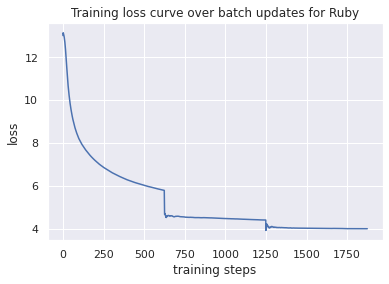

In [12]:
plt.plot(train_losses_ruby)
# plt.ylim(bottom=0)
plt.xlabel('training steps')
plt.ylabel('loss')
plt.title('Training loss curve over batch updates for Ruby')
plt.show();

### Python

In [13]:
# Parameters
lang                 = 'python'
data_dir             = 'dataset'
load_model_path      = None
output_dir           = os.path.join('outputs_codebert', lang)
load_model_path_test = os.path.join(output_dir, 'checkpoint-best-ppl', 'checkpoint-best-bleu', 'pytorch_model.bin') #checkpoint for test
train_filename       = os.path.join(data_dir, lang, 'train_sample.jsonl') # 'train.jsonl'
dev_filename         = os.path.join(data_dir, lang, 'valid_sample.jsonl') # 'valid.jsonl'
test_filename        = os.path.join(data_dir, lang, 'test_sample.jsonl') # 'test.jsonl'
do_train             = True
do_eval              = True
do_test              = False

In [14]:
train_losses_python = train_dev_test(tokenizer, model, device, train_filename, max_source_length, max_target_length, learning_rate, adam_epsilon, 
            local_rank, train_batch_size, gradient_accumulation_steps, train_steps, weight_decay, 
            num_train_epochs, n_gpu, do_train, do_eval, dev_filename, eval_batch_size, 
            output_dir, do_test, test_filename, test_batch_size, load_model_path_test)

05/09/2022 09:02:03 - INFO - __main__ -   ***** Running training *****
05/09/2022 09:02:03 - INFO - __main__ -     Num examples = 20000
05/09/2022 09:02:03 - INFO - __main__ -     Batch size = 32
05/09/2022 09:02:03 - INFO - __main__ -     Num epoch = 3
epoch 0 loss 4.425: 100%|██████████| 625/625 [03:26<00:00,  3.03it/s] 
05/09/2022 09:05:32 - INFO - __main__ -   
***** Running evaluation *****
05/09/2022 09:05:32 - INFO - __main__ -     Num examples = 1400
05/09/2022 09:05:32 - INFO - __main__ -     Batch size = 32
05/09/2022 09:05:38 - INFO - __main__ -     eval_ppl = 80.74343
05/09/2022 09:05:38 - INFO - __main__ -     global_step = 626
05/09/2022 09:05:38 - INFO - __main__ -     train_loss = 4.425
05/09/2022 09:05:38 - INFO - __main__ -     ********************
05/09/2022 09:05:40 - INFO - __main__ -     Best ppl:80.74343
05/09/2022 09:05:40 - INFO - __main__ -     ********************
Total: 1000
05/09/2022 09:07:16 - INFO - __main__ -     bleu-4 = 13.93 
05/09/2022 09:07:16 - IN

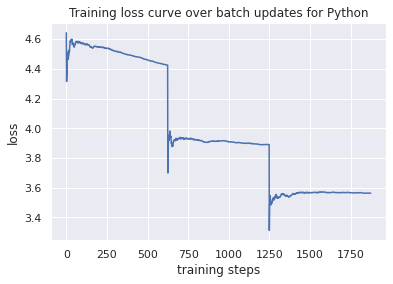

In [15]:
plt.plot(train_losses_python)
# plt.ylim(bottom=0)
plt.xlabel('training steps')
plt.ylabel('loss')
plt.title('Training loss curve over batch updates for Python')
plt.show();

### Java

In [16]:
# Parameters
lang                 = 'java'
data_dir             = 'dataset'
load_model_path      = None
output_dir           = os.path.join('outputs_codebert', lang)
load_model_path_test = os.path.join(output_dir, 'checkpoint-best-ppl', 'checkpoint-best-bleu', 'pytorch_model.bin') #checkpoint for test
train_filename       = os.path.join(data_dir, lang, 'train_sample.jsonl') # 'train.jsonl'
dev_filename         = os.path.join(data_dir, lang, 'valid_sample.jsonl') # 'valid.jsonl'
test_filename        = os.path.join(data_dir, lang, 'test_sample.jsonl') # 'test.jsonl'
do_train             = True
do_eval              = True
do_test              = False

In [17]:
train_losses_java = train_dev_test(tokenizer, model, device, train_filename, max_source_length, max_target_length, learning_rate, adam_epsilon, 
            local_rank, train_batch_size, gradient_accumulation_steps, train_steps, weight_decay, 
            num_train_epochs, n_gpu, do_train, do_eval, dev_filename, eval_batch_size, 
            output_dir, do_test, test_filename, test_batch_size, load_model_path_test)

05/09/2022 09:18:38 - INFO - __main__ -   ***** Running training *****
05/09/2022 09:18:38 - INFO - __main__ -     Num examples = 20000
05/09/2022 09:18:38 - INFO - __main__ -     Batch size = 32
05/09/2022 09:18:38 - INFO - __main__ -     Num epoch = 3
epoch 0 loss 3.8932: 100%|██████████| 625/625 [03:25<00:00,  3.04it/s]
05/09/2022 09:22:07 - INFO - __main__ -   
***** Running evaluation *****
05/09/2022 09:22:07 - INFO - __main__ -     Num examples = 1400
05/09/2022 09:22:07 - INFO - __main__ -     Batch size = 32
05/09/2022 09:22:12 - INFO - __main__ -     eval_ppl = 41.56432
05/09/2022 09:22:12 - INFO - __main__ -     global_step = 626
05/09/2022 09:22:12 - INFO - __main__ -     train_loss = 3.8932
05/09/2022 09:22:12 - INFO - __main__ -     ********************
05/09/2022 09:22:14 - INFO - __main__ -     Best ppl:41.56432
05/09/2022 09:22:14 - INFO - __main__ -     ********************
Total: 1000
05/09/2022 09:23:57 - INFO - __main__ -     bleu-4 = 14.7 
05/09/2022 09:23:57 - IN

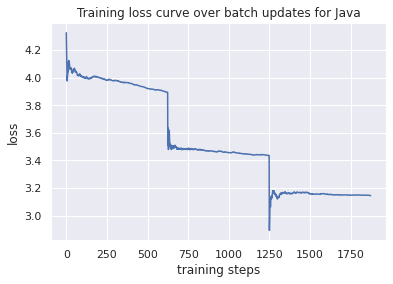

In [18]:
plt.plot(train_losses_java)
# plt.ylim(bottom=0)
plt.xlabel('training steps')
plt.ylabel('loss')
plt.title('Training loss curve over batch updates for Java')
plt.show();

### JavaScript

In [19]:
# Parameters
lang                 = 'javascript'
data_dir             = 'dataset'
load_model_path      = None
output_dir           = os.path.join('outputs_codebert', lang)
load_model_path_test = os.path.join(output_dir, 'checkpoint-best-ppl', 'checkpoint-best-bleu', 'pytorch_model.bin') #checkpoint for test
train_filename       = os.path.join(data_dir, lang, 'train_sample.jsonl') # 'train.jsonl'
dev_filename         = os.path.join(data_dir, lang, 'valid_sample.jsonl') # 'valid.jsonl'
test_filename        = os.path.join(data_dir, lang, 'test_sample.jsonl') # 'test.jsonl'
do_train             = True
do_eval              = True
do_test              = False

In [20]:
train_losses_js = train_dev_test(tokenizer, model, device, train_filename, max_source_length, max_target_length, learning_rate, adam_epsilon, 
            local_rank, train_batch_size, gradient_accumulation_steps, train_steps, weight_decay, 
            num_train_epochs, n_gpu, do_train, do_eval, dev_filename, eval_batch_size, 
            output_dir, do_test, test_filename, test_batch_size, load_model_path_test)

05/09/2022 09:35:20 - INFO - __main__ -   ***** Running training *****
05/09/2022 09:35:20 - INFO - __main__ -     Num examples = 20000
05/09/2022 09:35:20 - INFO - __main__ -     Batch size = 32
05/09/2022 09:35:20 - INFO - __main__ -     Num epoch = 3
epoch 0 loss 4.146: 100%|██████████| 625/625 [03:26<00:00,  3.03it/s] 
05/09/2022 09:38:48 - INFO - __main__ -   
***** Running evaluation *****
05/09/2022 09:38:48 - INFO - __main__ -     Num examples = 1400
05/09/2022 09:38:48 - INFO - __main__ -     Batch size = 32
05/09/2022 09:38:54 - INFO - __main__ -     eval_ppl = 54.62184
05/09/2022 09:38:54 - INFO - __main__ -     global_step = 626
05/09/2022 09:38:54 - INFO - __main__ -     train_loss = 4.146
05/09/2022 09:38:54 - INFO - __main__ -     ********************
05/09/2022 09:38:56 - INFO - __main__ -     Best ppl:54.62184
05/09/2022 09:38:56 - INFO - __main__ -     ********************
Total: 1000
05/09/2022 09:40:40 - INFO - __main__ -     bleu-4 = 13.67 
05/09/2022 09:40:40 - IN

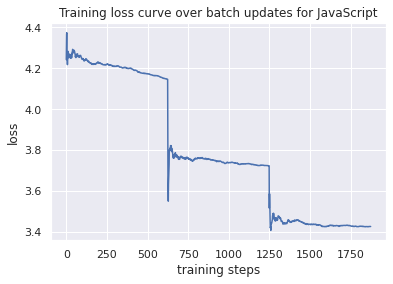

In [21]:
plt.plot(train_losses_js)
# plt.ylim(bottom=0)
plt.xlabel('training steps')
plt.ylabel('loss')
plt.title('Training loss curve over batch updates for JavaScript')
plt.show();

## Testing

### Ruby

In [22]:
# Parameters
lang                 = 'ruby'
data_dir             = 'dataset'
load_model_path      = None
output_dir           = os.path.join('outputs_codebert', lang)
load_model_path_test = os.path.join(output_dir, 'checkpoint-best-ppl', 'checkpoint-best-bleu', 'pytorch_model.bin') #checkpoint for test
train_filename       = os.path.join(data_dir, lang, 'train_sample.jsonl') # 'train.jsonl'
dev_filename         = os.path.join(data_dir, lang, 'valid_sample.jsonl') # 'valid.jsonl'
test_filename        = os.path.join(data_dir, lang, 'test_sample.jsonl') # 'test.jsonl'
do_train             = False
do_eval              = False
do_test              = True

In [23]:
_ = train_dev_test(tokenizer, model, device, train_filename, max_source_length, max_target_length, learning_rate, adam_epsilon, 
            local_rank, train_batch_size, gradient_accumulation_steps, train_steps, weight_decay, 
            num_train_epochs, n_gpu, do_train, do_eval, dev_filename, eval_batch_size, 
            output_dir, do_test, test_filename, test_batch_size, load_model_path_test)

05/09/2022 09:51:09 - INFO - __main__ -   Test file: dataset/ruby/valid_sample.jsonl
100%|██████████| 22/22 [01:56<00:00,  5.32s/it]
Total: 1400
05/09/2022 09:53:08 - INFO - __main__ -     bleu-4 = 13.06 
05/09/2022 09:53:08 - INFO - __main__ -     ********************
05/09/2022 09:53:08 - INFO - __main__ -   Test file: dataset/ruby/test_sample.jsonl
100%|██████████| 16/16 [01:27<00:00,  5.48s/it]
Total: 1000
05/09/2022 09:54:37 - INFO - __main__ -     bleu-4 = 12.55 
05/09/2022 09:54:37 - INFO - __main__ -     ********************


### Python

In [24]:
# Parameters
lang                 = 'python'
data_dir             = 'dataset'
load_model_path      = None
output_dir           = os.path.join('outputs_codebert', lang)
load_model_path_test = os.path.join(output_dir, 'checkpoint-best-ppl', 'checkpoint-best-bleu', 'pytorch_model.bin') #checkpoint for test
train_filename       = os.path.join(data_dir, lang, 'train_sample.jsonl') # 'train.jsonl'
dev_filename         = os.path.join(data_dir, lang, 'valid_sample.jsonl') # 'valid.jsonl'
test_filename        = os.path.join(data_dir, lang, 'test_sample.jsonl') # 'test.jsonl'
do_train             = False
do_eval              = False
do_test              = True

In [25]:
_ = train_dev_test(tokenizer, model, device, train_filename, max_source_length, max_target_length, learning_rate, adam_epsilon, 
            local_rank, train_batch_size, gradient_accumulation_steps, train_steps, weight_decay, 
            num_train_epochs, n_gpu, do_train, do_eval, dev_filename, eval_batch_size, 
            output_dir, do_test, test_filename, test_batch_size, load_model_path_test)

05/09/2022 09:54:37 - INFO - __main__ -   Test file: dataset/python/valid_sample.jsonl
100%|██████████| 22/22 [02:36<00:00,  7.13s/it]
Total: 1400
05/09/2022 09:57:16 - INFO - __main__ -     bleu-4 = 14.07 
05/09/2022 09:57:16 - INFO - __main__ -     ********************
05/09/2022 09:57:16 - INFO - __main__ -   Test file: dataset/python/test_sample.jsonl
100%|██████████| 16/16 [01:42<00:00,  6.41s/it]
Total: 1000
05/09/2022 09:59:00 - INFO - __main__ -     bleu-4 = 15.03 
05/09/2022 09:59:00 - INFO - __main__ -     ********************


### Java

In [26]:
# Parameters
lang                 = 'java'
data_dir             = 'dataset'
load_model_path      = None
output_dir           = os.path.join('outputs_codebert', lang)
load_model_path_test = os.path.join(output_dir, 'checkpoint-best-ppl', 'checkpoint-best-bleu', 'pytorch_model.bin') #checkpoint for test
train_filename       = os.path.join(data_dir, lang, 'train_sample.jsonl') # 'train.jsonl'
dev_filename         = os.path.join(data_dir, lang, 'valid_sample.jsonl') # 'valid.jsonl'
test_filename        = os.path.join(data_dir, lang, 'test_sample.jsonl') # 'test.jsonl'
do_train             = False
do_eval              = False
do_test              = True

In [27]:
_ = train_dev_test(tokenizer, model, device, train_filename, max_source_length, max_target_length, learning_rate, adam_epsilon, 
            local_rank, train_batch_size, gradient_accumulation_steps, train_steps, weight_decay, 
            num_train_epochs, n_gpu, do_train, do_eval, dev_filename, eval_batch_size, 
            output_dir, do_test, test_filename, test_batch_size, load_model_path_test)

05/09/2022 09:59:00 - INFO - __main__ -   Test file: dataset/java/valid_sample.jsonl
100%|██████████| 22/22 [02:14<00:00,  6.13s/it]
Total: 1400
05/09/2022 10:01:17 - INFO - __main__ -     bleu-4 = 14.92 
05/09/2022 10:01:17 - INFO - __main__ -     ********************
05/09/2022 10:01:17 - INFO - __main__ -   Test file: dataset/java/test_sample.jsonl
100%|██████████| 16/16 [01:31<00:00,  5.70s/it]
Total: 1000
05/09/2022 10:02:51 - INFO - __main__ -     bleu-4 = 14.76 
05/09/2022 10:02:51 - INFO - __main__ -     ********************


### JavaScript

In [28]:
# Parameters
lang                 = 'javascript'
data_dir             = 'dataset'
load_model_path      = None
output_dir           = os.path.join('outputs_codebert', lang)
load_model_path_test = os.path.join(output_dir, 'checkpoint-best-ppl', 'checkpoint-best-bleu', 'pytorch_model.bin') #checkpoint for test
train_filename       = os.path.join(data_dir, lang, 'train_sample.jsonl') # 'train.jsonl'
dev_filename         = os.path.join(data_dir, lang, 'valid_sample.jsonl') # 'valid.jsonl'
test_filename        = os.path.join(data_dir, lang, 'test_sample.jsonl') # 'test.jsonl'
do_train             = False
do_eval              = False
do_test              = True

In [29]:
_ = train_dev_test(tokenizer, model, device, train_filename, max_source_length, max_target_length, learning_rate, adam_epsilon, 
            local_rank, train_batch_size, gradient_accumulation_steps, train_steps, weight_decay, 
            num_train_epochs, n_gpu, do_train, do_eval, dev_filename, eval_batch_size, 
            output_dir, do_test, test_filename, test_batch_size, load_model_path_test)

05/09/2022 10:02:51 - INFO - __main__ -   Test file: dataset/javascript/valid_sample.jsonl
100%|██████████| 22/22 [02:08<00:00,  5.83s/it]
Total: 1400
05/09/2022 10:05:01 - INFO - __main__ -     bleu-4 = 14.29 
05/09/2022 10:05:01 - INFO - __main__ -     ********************
05/09/2022 10:05:01 - INFO - __main__ -   Test file: dataset/javascript/test_sample.jsonl
100%|██████████| 16/16 [01:32<00:00,  5.79s/it]
Total: 1000
05/09/2022 10:06:37 - INFO - __main__ -     bleu-4 = 13.24 
05/09/2022 10:06:37 - INFO - __main__ -     ********************


## Evaluation

In [30]:
!python ./evaluator.py ./outputs_codebert/ruby/test_1.gold < ./outputs_codebert/ruby/test_1.output

Total: 1000
12.551168227101355


In [31]:
!python ./evaluator.py ./outputs_codebert/python/test_1.gold < ./outputs_codebert/python/test_1.output

Total: 1000
15.0316239791071


In [32]:
!python ./evaluator.py ./outputs_codebert/java/test_1.gold < ./outputs_codebert/java/test_1.output

Total: 1000
14.755556602030326


In [33]:
!python ./evaluator.py ./outputs_codebert/javascript/test_1.gold < ./outputs_codebert/javascript/test_1.output

Total: 1000
13.23747822055244
